In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import glob
import cv2

from skimage.transform import resize

from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

from aim.segmentation.pneumothorax.visualize import display_images
from aim.segmentation.pneumothorax.dataset import generate_dataset

In [2]:
X_train, Y_train, X_valid, Y_valid = generate_dataset(
    '../data/pneumothorax_segmentation/dicom-images-train/*/*/*.dcm',
    '../data/pneumothorax_segmentation/train-rle.csv')

dataset size           : 12089 dicom files
training dataset size  : 10881  dicom files
validation dataset size: 1208   dicom files
generating training dataset
Key 1.2.276.0.7230010.3.1.4.8323329.6082.1517875196.407031 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.11577.1517875233.694347 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.4134.1517875181.277174 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.10599.1517875224.488727 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.11557.1517875233.601090 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.2630.1517875173.773726 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.11215.1517875231.757436 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.10407.1517875223.567351 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.5087.151

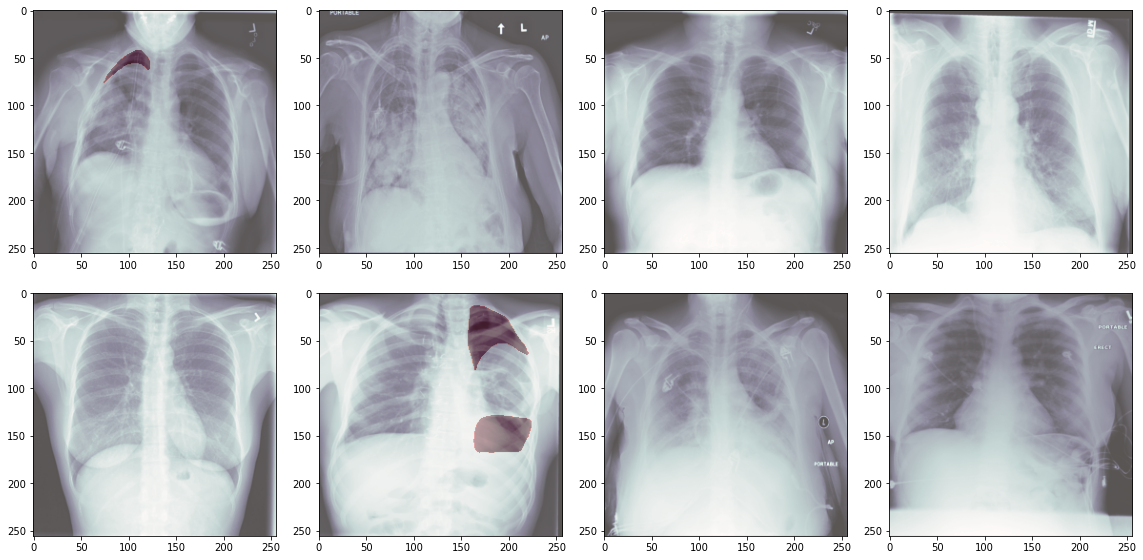

In [14]:
start = 55
end = start + 8
display_images(num_cols=4, num_rows=2, X=X_train[start:end], Y=Y_train[start:end])

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    dice_numerator = K.sum(y_true * y_pred, axis=axis)
    dice_denominator = K.sum(K.square(y_true), axis=axis) + K.sum(K.square(y_pred), axis=axis)
    dice_loss = 1 - K.mean((2 * dice_numerator + epsilon) / (dice_denominator + epsilon))

    ### END CODE HERE ###

    return dice_loss

In [ ]:
inputs = Input((None, None, im_chan))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=soft_dice_loss, metrics=[dice_coef])
model.summary()

In [ ]:
model.fit(X_train_resize, Y_train_resize, validation_split=.2, batch_size=32, epochs=50)